## 数据预处理

In [30]:
from urllib2 import urlopen
import os
import tarfile
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
all_df = pd.read_excel('titanic3.xls')

In [9]:
cols = ['survived','name','pclass','sex','age','sibsp','parch','fare','embarked']
all_df = all_df[cols]

In [13]:
msk = numpy.random.rand(len(all_df)) < 0.8
train_df = all_df[msk]
test_df = all_df[~msk]

In [15]:
print('total:', len(all_df),
     'train:', len(train_df),
     'test:', len(test_df))

('total:', 1309, 'train:', 1043, 'test:', 266)


In [19]:
from sklearn import preprocessing
def PreprocessData(raw_df):
    df = raw_df.drop(['name'], axis=1)
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean) #使用年龄的均值来填充缺失数据
    fare_mean = df['fare'].mean()
    df['fare'] = df['fare'].fillna(fare_mean)
    df['sex'] = df['sex'].map({'female':0,'male':1}).astype(int)  #转成数值型
    x_OneHot_df = pd.get_dummies(data=df, columns=['embarked'])
    
    ndarray = x_OneHot_df.values
    Features = ndarray[:, 1:]
    Label = ndarray[:, 0]
    
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaledFeatures = minmax_scale.fit_transform(Features)
    
    return scaledFeatures, Label

In [20]:
train_Features, train_Label = PreprocessData(train_df)
test_Features, test_Label = PreprocessData(test_df)

## 建立模型

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [22]:
model = Sequential()

In [23]:
model.add(Dense(units=40, input_dim=9,
               kernel_initializer='uniform',
               activation='relu'))

In [24]:
model.add(Dense(units=30, kernel_initializer='uniform', activation='relu'))

In [25]:
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 1,661
Trainable params: 1,661
Non-trainable params: 0
_________________________________________________________________


## 开始训练

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
train_history = model.fit(x=train_Features, y=train_Label, validation_split=0.1,
                         epochs=30,batch_size=30, verbose=2)

Train on 938 samples, validate on 105 samples
Epoch 1/30
0s - loss: 0.6899 - acc: 0.5874 - val_loss: 0.6745 - val_acc: 0.7619
Epoch 2/30
0s - loss: 0.6676 - acc: 0.6418 - val_loss: 0.6069 - val_acc: 0.7619
Epoch 3/30
0s - loss: 0.6044 - acc: 0.7058 - val_loss: 0.5091 - val_acc: 0.7905
Epoch 4/30
0s - loss: 0.5380 - acc: 0.7655 - val_loss: 0.4669 - val_acc: 0.8000
Epoch 5/30
0s - loss: 0.5015 - acc: 0.7633 - val_loss: 0.4559 - val_acc: 0.8000
Epoch 6/30
0s - loss: 0.4893 - acc: 0.7665 - val_loss: 0.4570 - val_acc: 0.8000
Epoch 7/30
0s - loss: 0.4835 - acc: 0.7687 - val_loss: 0.4511 - val_acc: 0.8190
Epoch 8/30
0s - loss: 0.4818 - acc: 0.7772 - val_loss: 0.4510 - val_acc: 0.8190
Epoch 9/30
0s - loss: 0.4786 - acc: 0.7804 - val_loss: 0.4504 - val_acc: 0.8095
Epoch 10/30
0s - loss: 0.4770 - acc: 0.7825 - val_loss: 0.4500 - val_acc: 0.8095
Epoch 11/30
0s - loss: 0.4731 - acc: 0.7825 - val_loss: 0.4476 - val_acc: 0.8286
Epoch 12/30
0s - loss: 0.4710 - acc: 0.7825 - val_loss: 0.4474 - val_acc

In [31]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()

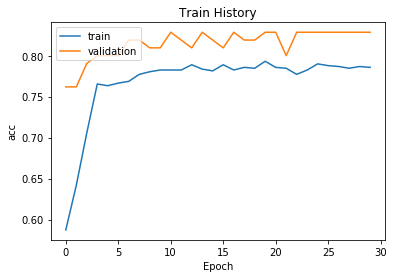

In [32]:
show_train_history(train_history, 'acc','val_acc')

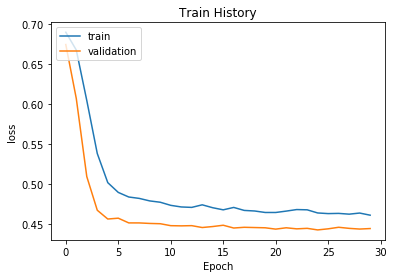

In [33]:
show_train_history(train_history, 'loss', 'val_loss')

## 评估模型准确率

In [34]:
scores = model.evaluate(x=test_Features, y=test_Label)

 32/266 [==>...........................] - ETA: 0s

In [35]:
scores[1]

0.84962406059853113

## 进行预测

In [37]:
all_Features, Label = PreprocessData(all_df)
all_probability = model.predict(all_Features)

In [39]:
pd = all_df
pd.insert(len(all_df.columns), 'probability', all_probability)

## Badcase分析
### 查看生存概率高,却没有存活的乘客

In [40]:
#获取生存概率大于90%但是没有存活的数据
pd[(pd['survived']==0) & (pd['probability']>0.9)]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
2,0,"Allison, Miss. Helen Loraine",1,female,2.0,1,2,151.5500,S,0.960650
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0,1,2,151.5500,S,0.956297
105,0,"Evans, Miss. Edith Corse",1,female,36.0,0,0,31.6792,C,0.969703
169,0,"Isham, Miss. Ann Elizabeth",1,female,50.0,0,0,28.7125,C,0.966713
286,0,"Straus, Mrs. Isidor (Rosalie Ida Blun)",1,female,63.0,1,0,221.7792,S,0.944426


通过分析badcase,我们可以把name的家族名称作为一个特征项